# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [3]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prettytable

# Tensorflow for CPU users
#! pip install tensorflow
! pip install EMD-signal --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0 requires multiprocess<0.70.17, but you have multiprocess 0.70.18 which is incompatible.


In [4]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EMD, EEMD, CEEMDAN

import os, joblib
import openpyxl

import tensorflow as tf
# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional

from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

Mounted at /content/drive


In [5]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

## 2. Importing Final Datasts

In [6]:
final_df = pd.read_csv(data_path / "final_df.csv", index_col=0, parse_dates=True)
final_df_scaled = pd.read_csv(data_path / "final_df_scaled.csv", index_col=0, parse_dates=True)

In [7]:
# # === Path to saved datasets ===
# data_path = Path("final_datasets")

# # === Read datasets (with Date as index) ===
# final_df = pd.read_csv(data_path / "final_df.csv", index_col=0, parse_dates=True)
# final_df_scaled = pd.read_csv(data_path / "final_df_scaled.csv", index_col=0, parse_dates=True)

# print("Datasets loaded successfully:")
# print("final_df shape:", final_df.shape)
# print("final_df_scaled shape:", final_df_scaled.shape)

## 3. Feature Importance and Selection

### a. Dataset Split

In [8]:
# For Scaled Data
X_scaled = final_df_scaled.drop(columns=['Sales (Rmn)', 'Volume'])
y1_scaled = final_df_scaled['Sales (Rmn)']
y2_scaled = final_df_scaled['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train_scaled, X_test_scaled = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y1_train_scaled, y1_test_scaled = y1_scaled.iloc[train_idx], y1_scaled.iloc[test_idx]
    y2_train_scaled, y2_test_scaled = y2_scaled.iloc[train_idx], y2_scaled.iloc[test_idx]


# For Raw Data
X = final_df.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = final_df['Sales (Rmn)']
y2 = final_df['Volume']

### b. Correlation Heatmap

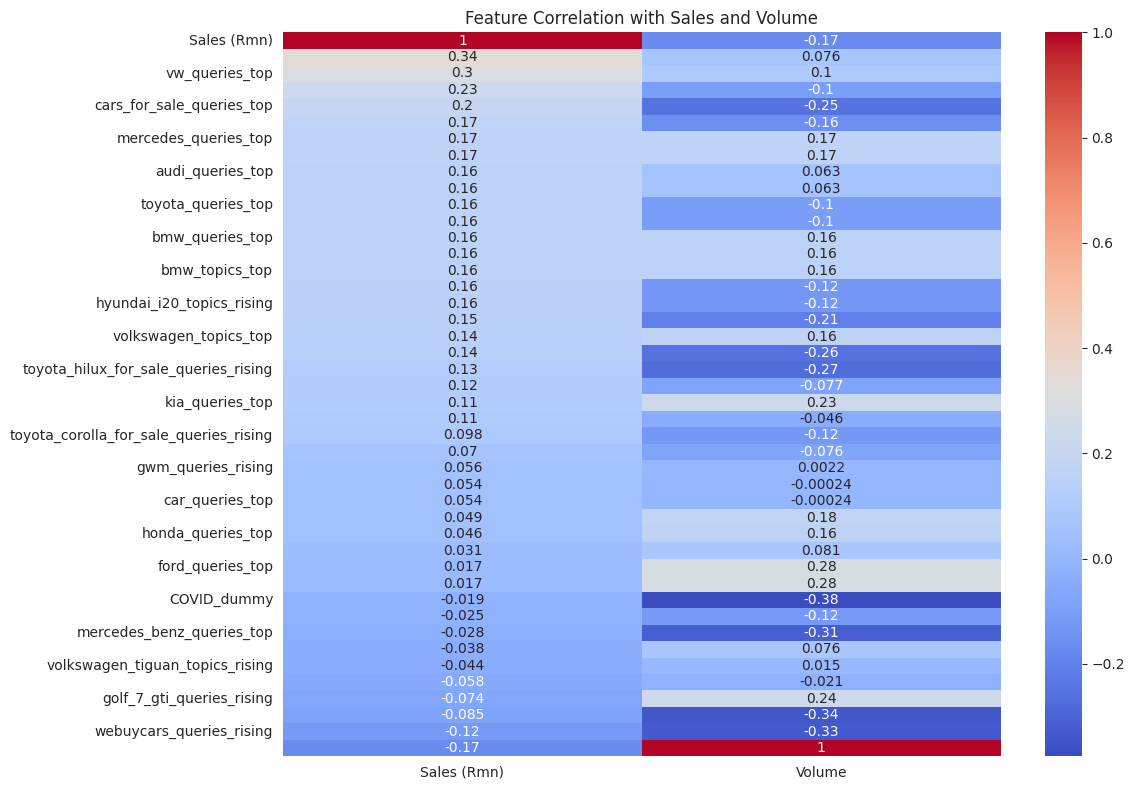

In [9]:
# Check correlations with Sales and Volume
correlation = final_df.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

### c. Granger Causality Tests

In [10]:
# === Function to run Granger causality tests ===
def granger_test_summary(X_train, y_train, maxlag=4, target_name="Target"):
    """
    Run Granger causality tests for each predictor in X_train against y_train.
    Returns DataFrame of significant predictors.
    """
    results = []
    df = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
    df.columns = [target_name] + list(X_train.columns)

    for predictor in X_train.columns:
        try:
            combined = df[[target_name, predictor]].dropna()
            test_result = grangercausalitytests(combined, maxlag=maxlag, verbose=False)
            # Get minimum p-value across lags
            p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
            min_p = min(p_values)
            if min_p < 0.05:
                results.append((predictor, min_p))
        except Exception as e:
            print(f"Skipped {predictor}: {e}")

    results_df = pd.DataFrame(results, columns=["Predictor", "Min_pvalue"]).sort_values("Min_pvalue")

    if results_df.empty:
        print(f"\nFor {target_name} no predictors were found significant at 5% level.")
    else:
        print(f"\nFor {target_name} the following predictors are significant:")
        for _, row in results_df.iterrows():
            print(f"- {row['Predictor']} (p={row['Min_pvalue']:.4f})")

    return results_df


# === Create Train/Validation/Test with TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_scaled))

# Use second-to-last split for train/validation, last split for test
train_idx, val_idx = splits[-2]
_, test_idx = splits[-1]

# Unscaled splits
X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y1_train, y1_val, y1_test = y1.iloc[train_idx], y1.iloc[val_idx], y1.iloc[test_idx]
y2_train, y2_val, y2_test = y2.iloc[train_idx], y2.iloc[val_idx], y2.iloc[test_idx]

# Scaled splits
X_train_scaled, X_val_scaled, X_test_scaled = (
    X_scaled.iloc[train_idx],
    X_scaled.iloc[val_idx],
    X_scaled.iloc[test_idx],
)
y1_train_scaled, y1_val_scaled, y1_test_scaled = (
    y1_scaled.iloc[train_idx],
    y1_scaled.iloc[val_idx],
    y1_scaled.iloc[test_idx],
)
y2_train_scaled, y2_val_scaled, y2_test_scaled = (
    y2_scaled.iloc[train_idx],
    y2_scaled.iloc[val_idx],
    y2_scaled.iloc[test_idx],
)


# === Run Granger causality on training set ===
# Sales
sales_significant = granger_test_summary(X_train_scaled, y1_train_scaled, maxlag=4, target_name="Sales")
sales_predictors = sales_significant["Predictor"].tolist()

# Volume
volume_significant = granger_test_summary(X_train_scaled, y2_train_scaled, maxlag=4, target_name="Volume")
volume_predictors = volume_significant["Predictor"].tolist()


# === Reduce datasets (scaled + unscaled) ===
# Sales
X1_train_scaled = X_train_scaled[sales_predictors]
X1_val_scaled = X_val_scaled[sales_predictors]
X1_test_scaled = X_test_scaled[sales_predictors]

X1_train = X_train[sales_predictors]
X1_val = X_val[sales_predictors]
X1_test = X_test[sales_predictors]

# Volume
X2_train_scaled = X_train_scaled[volume_predictors]
X2_val_scaled = X_val_scaled[volume_predictors]
X2_test_scaled = X_test_scaled[volume_predictors]

X2_train = X_train[volume_predictors]
X2_val = X_val[volume_predictors]
X2_test = X_test[volume_predictors]

Skipped volkwagen_polo_topics_top: The x values include a column with constant values and so the test statistic cannot be computed.

For Sales the following predictors are significant:
- golf_6_gti_queries_rising (p=0.0064)
- hyundai_queries_top (p=0.0077)
- autotrader_queries_top (p=0.0107)
- polo_vivo_queries_rising (p=0.0109)
- ford_figo_queries_rising (p=0.0219)
Skipped volkwagen_polo_topics_top: The x values include a column with constant values and so the test statistic cannot be computed.

For Volume the following predictors are significant:
- suzuki_queries_top (p=0.0000)
- mercedes_benz_queries_top (p=0.0000)
- autotrader_queries_top (p=0.0009)
- toyota_topics_top (p=0.0023)
- toyota_queries_top (p=0.0023)
- audi_queries_top (p=0.0030)
- audi_topics_top (p=0.0030)
- hyundai_queries_top (p=0.0064)
- cars_for_sale_queries_top (p=0.0111)
- kia_queries_top (p=0.0146)
- car_topics_top (p=0.0158)
- car_queries_top (p=0.0158)
- gwm_queries_rising (p=0.0309)
- honda_queries_top (p=0.0

### d. Feature Importance/Selection

In [11]:
def filter_features_by_importance(X, y, threshold=0.001, n_estimators=200, n_repeats=30, random_state=42):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(pfi.importances_mean)
    }).sort_values(by='Importance', ascending=False)

    # Ensure it's a list, not a Series
    important_features = importance_df.loc[importance_df['Importance'] > threshold, 'Feature'].tolist()

    X_filtered = X[important_features]

    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*60)
    print("Top 10 Permutation Feature Importances:")
    print(importance_df.head(10))

    return important_features, importance_df

In [12]:
# --- Sales ---
sales_final_features, sales_importance_df = filter_features_by_importance(X1_train_scaled, y1_train_scaled, threshold=0.1)

# Update all splits (scaled + unscaled) with final features
X1_train_scaled = X1_train_scaled[sales_final_features]
X1_val_scaled   = X1_val_scaled[sales_final_features]
X1_test_scaled  = X1_test_scaled[sales_final_features]

X1_train = X1_train[sales_final_features]
X1_val   = X1_val[sales_final_features]
X1_test  = X1_test[sales_final_features]


Number of features before filtering: 5
Number of features after filtering: 5
Number of features dropped: 0
Top 10 Permutation Feature Importances:
                     Feature  Importance
1        hyundai_queries_top    1.377008
4   ford_figo_queries_rising    1.061681
2     autotrader_queries_top    0.333267
0  golf_6_gti_queries_rising    0.189524
3   polo_vivo_queries_rising    0.188871


In [13]:
# --- Volume ---
volume_final_features, volume_importance_df = filter_features_by_importance(X2_train_scaled, y2_train_scaled, threshold=0.1)

# Update all splits (scaled + unscaled) with final features
X2_train_scaled = X2_train_scaled[volume_final_features]
X2_val_scaled   = X2_val_scaled[volume_final_features]
X2_test_scaled  = X2_test_scaled[volume_final_features]

X2_train = X2_train[volume_final_features]
X2_val   = X2_val[volume_final_features]
X2_test  = X2_test[volume_final_features]


Number of features before filtering: 16
Number of features after filtering: 2
Number of features dropped: 14
Top 10 Permutation Feature Importances:
                      Feature  Importance
0          suzuki_queries_top    0.567467
2      autotrader_queries_top    0.326092
12         gwm_queries_rising    0.067228
15           opel_queries_top    0.061309
8   cars_for_sale_queries_top    0.033675
4          toyota_queries_top    0.028663
5            audi_queries_top    0.027888
3           toyota_topics_top    0.027455
7         hyundai_queries_top    0.022064
6             audi_topics_top    0.018972


## 7. Decomposition

## 7. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>An extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. It captures both short-term and long-term dependencies within the data</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>A variant of the regression version of the Support Vector Machines (SVM). It tries to fit a function that predicts future values while keeping prediction errors within a certain margin (ε-insensitive loss function).</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>A type of neural network that excels in this area. Unlike simple models, LSTMs can remember information for long periods, making them ideal for time series tasks where past data influences future values.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BI-LSTM</td>
      <td>An Extension of the LSTM model that integrates the input information from both past and future time steps. It's like predicting the middle words of a sentence by knowing both its first and last words.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines the CNNs power of learning local patterns in data, with the LSTMs ability to capture long-term dependencies in sequential data.</td>
      <td>Deep Learning</td>
    </tr>
  </tbody>
</table>

### a. Helper Functions

In [14]:
# ---------------------------
# FULL UPDATED HELPER FUNCTIONS
# ---------------------------

# ---------------------------
# Utility: lag creators
# ---------------------------
def create_lags(y, lags=12):
    """Return DataFrame with column 'y' and lag_1..lag_lags, dropping NA."""
    df = pd.DataFrame({'y': np.asarray(y).flatten()})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

def create_multivariate_lags(X, y, lags=12):
    """
    Create 3D array X_lagged with shape (n_samples, lags, n_features)
    and vector y_lagged aligned to those windows.
    """
    X_lagged, y_lagged = [], []
    X = np.asarray(X)
    y = np.asarray(y).flatten()
    for i in range(lags, len(X)):
        X_lagged.append(X[i-lags:i, :])
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged)

# ---------------------------
# Residual-based confidence interval utility
# ---------------------------
def compute_residual_ci(y_train, y_pred, alpha=0.05):
    """
    Approximate symmetric CI around y_pred using residual std from aligned tail of y_train.
    Handles differing lengths by aligning the last min(len(y_train), len(y_pred)) points.
    Returns arrays lower, upper of same length as y_pred.
    """
    y_train = np.asarray(y_train).flatten()
    y_pred = np.asarray(y_pred).flatten()
    if len(y_train) == 0:
        sigma = 0.0
    else:
        m = min(len(y_train), len(y_pred))
        if m <= 1:
            resid = y_train[-m:] - y_pred[:m] if m == 1 else np.array([0.0])
            sigma = np.std(resid) if len(resid) > 0 else 0.0
        else:
            resid = y_train[-m:] - y_pred[:m]
            sigma = np.std(resid, ddof=1)
    z = 1.96  # approx for 95% CI
    lower = y_pred - z * sigma
    upper = y_pred + z * sigma
    return lower, upper

# ---------------------------
# Metrics & evaluation
# ---------------------------
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = np.asarray(y_true).flatten() - np.asarray(y_pred).flatten()[:n]
    sigma2 = np.var(resid) if np.var(resid) > 0 else 1e-8
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()[:len(y_true)]
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom))

def evaluate_model(name, y_true, y_pred, k):
    """
    Return list matching your results table columns:
    [name, AIC, BIC, RMSE, MAE, MAPE, R2] rounded to 2 decimal places
    """
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()[:len(y_true)]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    aic, bic = calculate_aic_bic(y_true, y_pred, k)

    # Round all metrics to 2 decimals
    return [name,
            round(float(aic), 2),
            round(float(bic), 2),
            round(float(rmse), 2),
            round(float(mae), 2),
            round(float(mape), 2),
            round(float(r2), 2)]

# ---------------------------
# Baseline model training functions
# --------------------------
def train_sarima(y, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    """
    Fit SARIMAX on y (1D array-like). Return (results, forecast, (lower, upper))
    """
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps)
    forecast = np.asarray(forecast_obj.predicted_mean)
    ci = np.asarray(forecast_obj.conf_int()).T
    lower, upper = ci[0], ci[1]
    return results, forecast, (lower, upper)

def train_sarimax(y, exog, exog_future, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    """
    Fit SARIMAX with exogenous variables.
    y: 1d array-like (train)
    exog: 2D array-like aligned to y
    exog_future: 2D array-like for forecast horizon
    """
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps, exog=exog_future)
    forecast = np.asarray(forecast_obj.predicted_mean)
    ci = np.asarray(forecast_obj.conf_int()).T
    lower, upper = ci[0], ci[1]
    return results, forecast, (lower, upper)

def train_svr(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    """
    Train SVR on X_train/y_train and predict on X_test.
    Returns (model, forecast, (lower, upper)) where CI is approximated from train residuals.
    """
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(np.asarray(X_train), np.asarray(y_train).ravel())
    forecast = model.predict(np.asarray(X_test))
    lower, upper = compute_residual_ci(y_train, model.predict(X_train))
    # Broadcast to test horizon in a stable way
    lower = np.repeat(np.mean(lower), len(forecast)) + (forecast - np.mean(forecast))
    upper = np.repeat(np.mean(upper), len(forecast)) + (forecast - np.mean(forecast))
    return model, np.asarray(forecast), (lower, upper)

def train_svr_multivariate(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    return train_svr(X_train, y_train, X_test, kernel=kernel, C=C, gamma=gamma)

# ---------------------------
# Simple NN builder + training wrappers
# ---------------------------
def build_model(model_type, input_shape, units=64, filters=64, kernel_size=3, pool_size=2, lr=0.001, dropout=0.2):
    """
    Build and compile a simple NN for regression:
    - model_type: "lstm", "bilstm", "cnnlstm", "gru"
    - input_shape: (timesteps, features)
    """
    model = Sequential()
    if model_type == "lstm":
        model.add(LSTM(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(max(1, units//2), activation="tanh"))
    elif model_type == "bilstm":
        model.add(Bidirectional(LSTM(units, activation="tanh", return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(max(1, units//2), activation="tanh")))
    elif model_type == "cnnlstm":
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
        model.add(Conv1D(filters=max(4, filters//2), kernel_size=2, activation="relu"))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))
        model.add(LSTM(units, activation="tanh", return_sequences=True))
        model.add(LSTM(max(1, units//2), activation="tanh"))
    elif model_type == "gru":
        model.add(GRU(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(GRU(max(1, units//2), activation="tanh"))
    else:
        raise ValueError(f"Unknown model_type '{model_type}'. Supported: lstm, bilstm, cnnlstm, gru")
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

def train_nn_univariate(y_train, y_test, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Train a univariate NN using lagged windows and return (model, forecast)
    - y_train: 1D array (training series)
    - y_test: 1D array (test/forecast horizon)
    """
    y_train = np.asarray(y_train).flatten()
    # If training too short, fall back to mean forecast
    if len(y_train) <= lags:
        preds = np.repeat(np.mean(y_train), len(y_test))
        return None, np.asarray(preds)

    # Build lagged training matrix
    X_train = np.array([y_train[i-lags:i] for i in range(lags, len(y_train))])
    y_train_lag = y_train[lags:]
    X_train = X_train.reshape(-1, lags, 1)

    model = build_model(model_type, (lags, 1), **kwargs)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # recursive forecast (auto-regressive)
    forecast = []
    last_window = list(y_train[-lags:])
    for _ in range(len(y_test)):
        x_in = np.array(last_window[-lags:]).reshape(1, lags, 1)
        yhat = float(model.predict(x_in, verbose=0)[0, 0])
        forecast.append(yhat)
        last_window.append(yhat)

    forecast = np.asarray(forecast)
    return model, forecast

def train_nn_multivariate_direct(X_train_lagged, y_train_lagged, X_train_full, X_test_full,
                                 model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Train a multivariate NN on 3D X_train_lagged (n_samples, lags, n_feats) and y_train_lagged (vector)
    Returns (model, preds) where preds is length = X_test_full.shape[0].
    """
    if X_train_lagged.shape[0] == 0:
        return None, np.repeat(np.mean(y_train_lagged), X_test_full.shape[0])

    model = build_model(model_type, (X_train_lagged.shape[1], X_train_lagged.shape[2]), **kwargs)
    model.fit(X_train_lagged, y_train_lagged, epochs=epochs, batch_size=batch_size, verbose=0)

    # Build rolling windows from exogenous seed + test exog (seed = last lags of X_train_full)
    def build_test_windows_from_exog(X_train_full, X_test_full, lags):
        seed_plus_test = np.vstack([X_train_full[-lags:, :], X_test_full])
        return np.array([seed_plus_test[i:i+lags, :] for i in range(len(X_test_full))])

    X_test_windows = build_test_windows_from_exog(X_train_full, X_test_full, lags)
    preds = model.predict(X_test_windows, verbose=0).flatten()
    return model, np.asarray(preds)

# ---------------------------
# EEMD helpers
# ---------------------------
def apply_eemd(series, ensemble_size=50, noise_strength=0.2):
    """
    Return IMFs array (list of arrays) for the provided 1D series.
    Uses PyEMD.EEMD(trials=ensemble_size, noise_width=noise_strength).
    """
    series = np.asarray(series).flatten()
    eemd = EEMD(trials=ensemble_size, noise_width=noise_strength)
    IMFs = eemd.eemd(series)
    return IMFs

def _extract_preds_from_model_func_output(outputs, expected_len):
    """
    Accept outputs like: (model, preds), (model, preds, extra), preds array, or pandas Series.
    Return flattened numpy preds of length expected_len (or trim/pad if necessary).
    """
    # find first array-like in output tuple/list (search from end to prefer preds)
    preds = None
    if isinstance(outputs, (tuple, list)):
        for el in reversed(outputs):
            if isinstance(el, (np.ndarray, list, pd.Series)):
                preds = np.asarray(el).flatten()
                break
        if preds is None:
            # fallback to second element or first
            try:
                preds = np.asarray(outputs[1]).flatten()
            except Exception:
                preds = np.asarray(outputs[0]).flatten()
    elif isinstance(outputs, (np.ndarray, list, pd.Series)):
        preds = np.asarray(outputs).flatten()
    else:
        preds = np.asarray(outputs).flatten()

    # Trim or pad
    if len(preds) >= expected_len:
        return preds[:expected_len]
    else:
        if len(preds) == 0:
            return np.zeros(expected_len)
        pad = np.full(expected_len - len(preds), preds[-1])
        return np.concatenate([preds, pad])

def forecast_with_eemd_univariate(y_train, y_test, model_func, k, name,
                                  ensemble_size=50, noise_strength=0.2, alpha=0.05, return_forecast=False, **kwargs):
    """
    Decompose the concatenated series (y_train + y_test) with EEMD, fit model_func on each IMF
    (train_part, test_part) and sum the forecasts and the CI bands.
    model_func signature (train_part, test_part, **kwargs) -> (model, preds) or (model, preds, (lower, upper)) or preds
    Returns:
      - if return_forecast: (evaluate_model(...), (recon_preds, (recon_lower, recon_upper)))
      - else: evaluate_model(...)
    """
    # Decompose full series so that IMFs include both train and test parts
    series_full = np.concatenate([np.asarray(y_train).flatten(), np.asarray(y_test).flatten()])
    IMFs = apply_eemd(series_full, ensemble_size=ensemble_size, noise_strength=noise_strength)

    recon_preds = np.zeros(len(y_test))
    recon_lower = np.zeros(len(y_test))
    recon_upper = np.zeros(len(y_test))

    for imf in IMFs:
        imf = np.asarray(imf).flatten()
        if len(imf) != len(series_full):
            # skip irregular imfs
            continue

        # split into train/test
        train_part = imf[:-len(y_test)]
        test_part = imf[-len(y_test):]

        outputs = model_func(train_part, test_part, **kwargs)

        # Handle different return signatures
        if isinstance(outputs, (tuple, list)) and len(outputs) >= 3:
            preds = np.asarray(outputs[1]).flatten()
            lower, upper = outputs[2]
        else:
            preds = _extract_preds_from_model_func_output(outputs, len(y_test))
            lower, upper = compute_residual_ci(train_part, preds, alpha=alpha)

        preds = preds[:len(y_test)]
        lower = np.asarray(lower)[:len(y_test)]
        upper = np.asarray(upper)[:len(y_test)]

        recon_preds += preds
        recon_lower += lower
        recon_upper += upper

    eval_metrics = evaluate_model(name, y_test, recon_preds, k)
    if return_forecast:
        return eval_metrics, (recon_preds, (recon_lower, recon_upper))
    return eval_metrics

def forecast_with_eemd_multivariate(X_train, X_test, y_train, y_test, model_func, k, name,
                                    ensemble_size=50, noise_strength=0.2, alpha=0.05, return_forecast=False, **kwargs):
    """
    Decompose y (train+test) with EEMD, for each IMF fit model_func
    model_func(Xtr_aligned, ytr_imf, Xte, **kwargs) -> (model, preds) or (model, preds, (lower,upper)) or preds
    Returns evaluate_model(...) or (evaluate_model, (recon_preds,(lower,upper))) when return_forecast=True
    """
    series_full = np.concatenate([np.asarray(y_train).flatten(), np.asarray(y_test).flatten()])
    IMFs = apply_eemd(series_full, ensemble_size=ensemble_size, noise_strength=noise_strength)

    recon_preds = np.zeros(len(y_test))
    recon_lower = np.zeros(len(y_test))
    recon_upper = np.zeros(len(y_test))

    for imf in IMFs:
        imf = np.asarray(imf).flatten()
        if len(imf) != len(series_full):
            continue

        train_part = imf[:-len(y_test)]
        # Align X_train to the length of train_part (usually full X_train)
        if X_train.shape[0] < len(train_part):
            # can't align; skip
            continue
        X_train_aligned = X_train[-len(train_part):, :]

        outputs = model_func(X_train_aligned, train_part, X_test, **kwargs)

        if isinstance(outputs, (tuple, list)) and len(outputs) >= 3:
            preds = np.asarray(outputs[1]).flatten()
            lower, upper = outputs[2]
        else:
            preds = _extract_preds_from_model_func_output(outputs, len(y_test))
            lower, upper = compute_residual_ci(train_part, preds, alpha=alpha)

        preds = preds[:len(y_test)]
        lower = np.asarray(lower)[:len(y_test)]
        upper = np.asarray(upper)[:len(y_test)]

        recon_preds += preds
        recon_lower += lower
        recon_upper += upper

    eval_metrics = evaluate_model(name, y_test, recon_preds, k)
    if return_forecast:
        return eval_metrics, (recon_preds, (recon_lower, recon_upper))
    return eval_metrics

# ---------------------------
# Wrappers for univariate models (for EEMD usage)
# ---------------------------
def sarima_wrapper_univariate(y_train_tr, y_test_te, order=(0,1,1), seasonal_order=(0,0,2,12), **kwargs):
    results, preds, ci = train_sarima(y_train_tr, order=order, seasonal_order=seasonal_order, steps=len(y_test_te))
    return (results, np.asarray(preds), ci)

def svr_univariate_wrapper(y_train_tr, y_test_te, lags=12, **svr_kwargs):
    """
    Build lag features on the IMF train part, fit SVR, then recursively forecast for len(y_test_te).
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    if len(y_train_tr) <= lags:
        return (None, np.repeat(np.mean(y_train_tr), len(y_test_te)))
    df = create_lags(y_train_tr, lags=lags)
    X_tr = df.drop("y", axis=1).values
    y_tr = df["y"].values
    model = SVR(**{k: v for k, v in svr_kwargs.items() if k in ['kernel', 'C', 'gamma']})
    model.fit(X_tr, y_tr)
    last_window = list(y_train_tr[-lags:])
    preds = []
    for _ in range(len(y_test_te)):
        x_in = np.array(last_window[-lags:]).reshape(1, -1)
        yhat = float(model.predict(x_in)[0])
        preds.append(yhat)
        last_window.append(yhat)
    return (model, np.asarray(preds))

# Safe wrapper for train_svr (keeps compatibility)
def call_train_svr(X_train, y_train, X_test):
    out = train_svr(X_train, y_train, X_test)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], out[1]  # (model, forecast)
    else:
        return None, out       # forecast only

# Safe wrapper for train_svr_multivariate
def call_train_svr_multi(X_train, y_train, X_test):
    out = train_svr_multivariate(X_train, y_train, X_test)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], out[1]
    else:
        return None, out

def nn_univariate_wrapper(y_train_tr, y_test_te, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Return (model, preds) for use inside EEMD univariate wrapper.
    """
    return train_nn_univariate(y_train_tr, y_test_te, model_type=model_type, lags=lags, epochs=epochs, batch_size=batch_size, **kwargs)

# ---------------------------
# Wrappers for multivariate models (for EEMD usage)
# model_func expected signature: fn(X_train_aligned, y_train_imf, X_test)
# ---------------------------
def sarimax_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, order=(0,1,1), seasonal_order=(0,0,2,12), **kwargs):
    _, preds, ci = train_sarimax(ytr_imf, Xtr_aligned, Xte, order=order, seasonal_order=seasonal_order, steps=Xte.shape[0])
    return (None, np.asarray(preds), ci)

def svr_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, **svr_kwargs):
    model = SVR(**{k:v for k,v in svr_kwargs.items() if k in ['kernel','C','gamma']})
    model.fit(np.asarray(Xtr_aligned), np.asarray(ytr_imf).ravel())
    preds = model.predict(np.asarray(Xte))
    return (model, np.asarray(preds))

def nn_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Build lagged arrays from Xtr_aligned & ytr_imf and call the NN multivariate direct trainer.
    Returns (model, preds).
    """
    Xtr_lagged, ytr_lagged = create_multivariate_lags(Xtr_aligned, ytr_imf, lags=lags)
    if Xtr_lagged.shape[0] == 0:
        return (None, np.repeat(np.mean(ytr_imf), Xte.shape[0]))
    model, preds = train_nn_multivariate_direct(Xtr_lagged, ytr_lagged, Xtr_aligned, Xte,
                                                model_type=model_type, lags=lags, epochs=epochs, batch_size=batch_size, **kwargs)
    return (model, np.asarray(preds))

# ---------------------------
# Prophet & LightGBM wrappers
# ---------------------------
def prophet_univariate_wrapper(y_train_tr, y_test_te, freq='D', start_date='2000-01-01', **kwargs):
    """
    Fit Prophet on y_train_tr and forecast len(y_test_te).
    Returns (model, preds)
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    df_train = pd.DataFrame({
        "ds": pd.date_range(start=start_date, periods=len(y_train_tr), freq=freq),
        "y": y_train_tr
    })
    model = Prophet()
    model.fit(df_train)
    future = pd.DataFrame({"ds": pd.date_range(start=df_train["ds"].iloc[-1] + pd.Timedelta(1, unit=freq.lower()), periods=len(y_test_te), freq=freq)})
    forecast_df = model.predict(future)
    preds = forecast_df["yhat"].values
    return model, np.asarray(preds)

def lgb_univariate_wrapper(y_train_tr, y_test_te, lags=12, lgb_params=None):
    """
    Train LightGBM using lag features on y_train_tr and forecast recursively.
    Returns (model, preds)
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    if len(y_train_tr) <= lags:
        return None, np.repeat(np.mean(y_train_tr), len(y_test_te))
    df = create_lags(y_train_tr, lags=lags)
    X_tr = df.drop("y", axis=1).values
    y_tr = df["y"].values
    model = lgb.LGBMRegressor(**(lgb_params or {}))
    model.fit(X_tr, y_tr)
    last_window = list(y_train_tr[-lags:])
    preds = []
    for _ in range(len(y_test_te)):
        x_in = np.array(last_window[-lags:]).reshape(1, -1)
        yhat = float(model.predict(x_in)[0])
        preds.append(yhat)
        last_window.append(yhat)
    return model, np.asarray(preds)

def lgb_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, lgb_params=None):
    model = lgb.LGBMRegressor(**(lgb_params or {}))
    model.fit(np.asarray(Xtr_aligned), np.asarray(ytr_imf).ravel())
    preds = model.predict(np.asarray(Xte))
    return (model, np.asarray(preds))

# ---------------------------
# END OF HELPER FUNCTIONS
# ---------------------------


### b. Sales

#### i. Model Training

In [15]:
# ---------------------------
# MODEL TRAINING PIPELINE
# ---------------------------

# Ensure NumPy arrays
y1_train_np = y1_train_scaled.values.flatten() if hasattr(y1_train_scaled, "values") else y1_train_scaled.flatten()
y1_test_np  = y1_test_scaled.values.flatten()  if hasattr(y1_test_scaled, "values") else y1_test_scaled.flatten()
X1_train_np = X1_train_scaled.values if hasattr(X1_train_scaled, "values") else X1_train_scaled
X1_test_np  = X1_test_scaled.values  if hasattr(X1_test_scaled, "values") else X1_test_scaled

lags = 12
epochs = 30
batch_size = 8

# Containers
results_uni = []
forecasts_uni = {}
results_multi = []
forecasts_multi = {}

# ---------------------------
# ---- UNIVARIATE MODELS ----
# ---------------------------

# SARIMA
_, sarima_forecast, sarima_ci = train_sarima(y1_train_np, steps=len(y1_test_np))
results_uni.append(evaluate_model("SARIMA", y1_test_np, sarima_forecast, k=3))
forecasts_uni["SARIMA"] = (sarima_forecast, sarima_ci)

# LSSVR-Uni
_, lssvr_forecast = call_train_svr(X1_train_np[:, :1], y1_train_np, X1_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y1_train_np, lssvr_forecast)
results_uni.append(evaluate_model("LSSVR-Uni", y1_test_np, lssvr_forecast, k=1))
forecasts_uni["LSSVR-Uni"] = (lssvr_forecast, (lssvr_lower, lssvr_upper))

# LSTM-Uni
_, lstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y1_train_np, lstm_forecast)
results_uni.append(evaluate_model("LSTM-Uni", y1_test_np, lstm_forecast, k=lags+50))
forecasts_uni["LSTM-Uni"] = (lstm_forecast, (lstm_lower, lstm_upper))

# BiLSTM-Uni
_, bilstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y1_train_np, bilstm_forecast)
results_uni.append(evaluate_model("BiLSTM-Uni", y1_test_np, bilstm_forecast, k=lags+50))
forecasts_uni["BiLSTM-Uni"] = (bilstm_forecast, (bilstm_lower, bilstm_upper))

# CNN-LSTM-Uni
_, cnnlstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y1_train_np, cnnlstm_forecast)
results_uni.append(evaluate_model("CNN-LSTM-Uni", y1_test_np, cnnlstm_forecast, k=lags+50+64))
forecasts_uni["CNN-LSTM-Uni"] = (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))

# GRU-Uni
_, gru_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size)
gru_lower, gru_upper = compute_residual_ci(y1_train_np, gru_forecast)
results_uni.append(evaluate_model("GRU-Uni", y1_test_np, gru_forecast, k=lags+50))
forecasts_uni["GRU-Uni"] = (gru_forecast, (gru_lower, gru_upper))

# Prophet-Uni
_, prophet_forecast = prophet_univariate_wrapper(y1_train_np, y1_test_np)
results_uni.append(evaluate_model("PROPHET-Uni", y1_test_np, prophet_forecast, k=3))
forecasts_uni["PROPHET-Uni"] = (prophet_forecast, (None, None))

# LightGBM-Uni
_, lgb_forecast = lgb_univariate_wrapper(y1_train_np, y1_test_np, lags=lags)
lgb_lower, lgb_upper = compute_residual_ci(y1_train_np, lgb_forecast)
results_uni.append(evaluate_model("LIGHTGBM-Uni", y1_test_np, lgb_forecast, k=lags))
forecasts_uni["LIGHTGBM-Uni"] = (lgb_forecast, (lgb_lower, lgb_upper))

# ---------------------------
# ---- MULTIVARIATE MODELS ----
# ---------------------------
X1_train_nn_lagged, y1_train_nn_lagged = create_multivariate_lags(X1_train_np, y1_train_np, lags=lags)

# SARIMAX
_, sarimax_forecast, sarimax_ci = train_sarimax(y1_train_np, X1_train_np, X1_test_np, steps=len(y1_test_np))
results_multi.append(evaluate_model("SARIMAX-Multi", y1_test_np, sarimax_forecast, k=3+X1_train_np.shape[1]))
forecasts_multi["SARIMAX-Multi"] = (sarimax_forecast, sarimax_ci)

# LSSVR-Multi
_, lssvr_mv_forecast = call_train_svr_multi(X1_train_np, y1_train_np, X1_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y1_train_np, lssvr_mv_forecast)
results_multi.append(evaluate_model("LSSVR-Multi", y1_test_np, lssvr_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LSSVR-Multi"] = (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper))

# LSTM-Multi
_, lstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged, X1_train_np, X1_test_np,
                                                   model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y1_train_np, lstm_mv_forecast)
results_multi.append(evaluate_model("LSTM-Multi", y1_test_np, lstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LSTM-Multi"] = (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper))

# BiLSTM-Multi
_, bilstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged, X1_train_np, X1_test_np,
                                                     model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y1_train_np, bilstm_mv_forecast)
results_multi.append(evaluate_model("BiLSTM-Multi", y1_test_np, bilstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["BiLSTM-Multi"] = (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper))

# CNN-LSTM-Multi
_, cnnlstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged, X1_train_np, X1_test_np,
                                                     model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y1_train_np, cnnlstm_mv_forecast)
results_multi.append(evaluate_model("CNN-LSTM-Multi", y1_test_np, cnnlstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["CNN-LSTM-Multi"] = (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))

# GRU-Multi
_, gru_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged, X1_train_np, X1_test_np,
                                                 model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size)
gru_mv_lower, gru_mv_upper = compute_residual_ci(y1_train_np, gru_mv_forecast)
results_multi.append(evaluate_model("GRU-Multi", y1_test_np, gru_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["GRU-Multi"] = (gru_mv_forecast, (gru_mv_lower, gru_mv_upper))

# LightGBM-Multi
_, lgb_mv_forecast = lgb_multivariate_wrapper(X1_train_np, y1_train_np, X1_test_np)
lgb_mv_lower, lgb_mv_upper = compute_residual_ci(y1_train_np, lgb_mv_forecast)
results_multi.append(evaluate_model("LIGHTGBM-Multi", y1_test_np, lgb_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LIGHTGBM-Multi"] = (lgb_mv_forecast, (lgb_mv_lower, lgb_mv_upper))

# ---------------------------
# ---- EEMD-ENHANCED MODELS ----
# ---------------------------

ensemble_size = 50
noise_strength = 0.2
alpha = 0.05  # CI

# ---------------------------
# ---- UNIVARIATE EEMD ----
# ---------------------------

# SARIMA-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, sarima_wrapper_univariate, k=3,
    name="SARIMA-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_uni.append(metrics)
forecasts_uni["SARIMA-Uni_EEMD"] = (forecast, ci)

# LSSVR-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, svr_univariate_wrapper, k=lags,
    name="LSSVR-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True, lags=lags
)
results_uni.append(metrics)
forecasts_uni["LSSVR-Uni_EEMD"] = (forecast, ci)

# LSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, nn_univariate_wrapper, k=lags+50,
    name="LSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["LSTM-Uni_EEMD"] = (forecast, ci)

# BiLSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, nn_univariate_wrapper, k=lags+50,
    name="BiLSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["BiLSTM-Uni_EEMD"] = (forecast, ci)

# CNN-LSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, nn_univariate_wrapper, k=lags+50+64,
    name="CNN-LSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["CNN-LSTM-Uni_EEMD"] = (forecast, ci)

# GRU-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, nn_univariate_wrapper, k=lags+50,
    name="GRU-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["GRU-Uni_EEMD"] = (forecast, ci)

# Prophet-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, prophet_univariate_wrapper, k=3,
    name="PROPHET-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_uni.append(metrics)
forecasts_uni["PROPHET-Uni_EEMD"] = (forecast, ci)

# LightGBM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y1_train_np, y1_test_np, lgb_univariate_wrapper, k=lags,
    name="LIGHTGBM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    lags=lags
)
results_uni.append(metrics)
forecasts_uni["LIGHTGBM-Uni_EEMD"] = (forecast, ci)

# ---------------------------
# ---- MULTIVARIATE EEMD ----
# ---------------------------

# SARIMAX-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, sarimax_multivariate_wrapper, k=3+X1_train_np.shape[1],
    name="SARIMAX-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["SARIMAX-Multi_EEMD"] = (forecast, ci)

# LSSVR-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, svr_multivariate_wrapper, k=X1_train_np.shape[1],
    name="LSSVR-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["LSSVR-Multi_EEMD"] = (forecast, ci)

# LSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, nn_multivariate_wrapper, k=X1_train_np.shape[1],
    name="LSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["LSTM-Multi_EEMD"] = (forecast, ci)

# BiLSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, nn_multivariate_wrapper, k=X1_train_np.shape[1],
    name="BiLSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["BiLSTM-Multi_EEMD"] = (forecast, ci)

# CNN-LSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, nn_multivariate_wrapper, k=X1_train_np.shape[1],
    name="CNN-LSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["CNN-LSTM-Multi_EEMD"] = (forecast, ci)

# GRU-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, nn_multivariate_wrapper, k=X1_train_np.shape[1],
    name="GRU-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["GRU-Multi_EEMD"] = (forecast, ci)

# LightGBM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X1_train_np, X1_test_np, y1_train_np, y1_test_np, lgb_multivariate_wrapper, k=X1_train_np.shape[1],
    name="LIGHTGBM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["LIGHTGBM-Multi_EEMD"] = (forecast, ci)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/is5x0b42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/l2ybjlr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48030', 'data', 'file=/tmp/tmp16__pfhz/is5x0b42.json', 'init=/tmp/tmp16__pfhz/l2ybjlr9.json', 'output', 'file=/tmp/tmp16__pfhz/prophet_modelah_81zkj/prophet_model-20250909115440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 12
[LightGBM] [Info] Start training from score -0.000628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 5
[LightGBM] [Info] Start training from score -0.000691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/rmjj3mn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/uf1eo__e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94556', 'data', 'file=/tmp/tmp16__pfhz/rmjj3mn1.json', 'init=/tmp/tmp16__pfhz/uf1eo__e.json', 'output', 'file=/tmp/tmp16__pfhz/prophet_modelugptolrw/prophet_model-20250909120503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/kym7g_y7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16__pfhz/mphvmonb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 12
[LightGBM] [Info] Start training from score -0.000127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

#### ii. Results

In [16]:
# ---------------------------
# ---- RESULTS DATAFRAMES ----
# ---------------------------

# Univariate results DataFrame
df_results_uni = pd.DataFrame(results_uni, columns=[
    "Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R2"
])

# Multivariate results DataFrame
df_results_multi = pd.DataFrame(results_multi, columns=[
    "Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R2"
])

# Optional: display top 10 for quick inspection
print("=== Top Univariate Models ===")
df_results_uni

=== Top Univariate Models ===


,Model,AIC,BIC,RMSE,MAE,MAPE,R2
0,SARIMA,-138.26,-133.19,0.04,0.03,5.99,-0.11
1,LSSVR-Uni,-146.14,-144.45,0.05,0.04,5.25,-0.53
2,LSTM-Uni,-18.78,85.93,0.04,0.03,4.62,-0.17
3,BiLSTM-Uni,3.67,108.39,0.08,0.07,20.88,-2.91
4,CNN-LSTM-Uni,105.30,318.10,0.04,0.03,5.86,-0.05
5,GRU-Uni,-3.19,101.52,0.06,0.05,8.32,-1.44
6,PROPHET-Uni,-142.09,-137.03,0.04,0.03,1.08,-0.17
7,LIGHTGBM-Uni,-119.19,-98.92,0.05,0.03,3.31,-0.46
8,SARIMA-Uni_EEMD,-118.27,-113.21,0.08,0.07,47.06,-3.93
9,LSSVR-Uni_EEMD,-124.14,-103.88,0.04,0.03,2.05,-0.11


In [15]:
print("\n=== Top Multivariate Models ===")
df_results_multi


=== Top Multivariate Models ===


,Model,AIC,BIC,RMSE,MAE,MAPE,R2
0,SARIMAX-Multi,-130.41,-116.90,0.04,0.03,7.93,-0.05
1,LSSVR-Multi,-138.14,-129.70,0.05,0.04,5.25,-0.53
2,LSTM-Multi,-118.76,-110.32,0.05,0.04,2.12,-0.64
3,BiLSTM-Multi,-134.22,-125.78,0.04,0.03,4.73,-0.13
4,CNN-LSTM-Multi,-135.08,-126.64,0.04,0.03,4.91,-0.09
5,GRU-Multi,-134.68,-126.24,0.04,0.03,1.69,-0.23
6,LIGHTGBM-Multi,-131.61,-123.17,0.05,0.04,4.98,-0.74
7,SARIMAX-Multi_EEMD,-134.65,-121.14,0.04,0.03,10.57,0.05
8,LSSVR-Multi_EEMD,-138.14,-129.70,0.04,0.03,1.80,-0.12
9,LSTM-Multi_EEMD,-143.74,-135.30,0.04,0.03,14.35,-0.14


#### iii. Plots

In [1]:
def plot_forecasts(y_train_scaled, y_test_scaled, forecasts_dict, title="Forecast Plot"):
    """
    Interactive Plotly forecast visualization for univariate or multivariate models.

    Parameters
    ----------
    y_train_scaled : pd.Series or np.ndarray
        Training series (scaled)
    y_test_scaled : pd.Series or np.ndarray
        Test series (scaled)
    forecasts_dict : dict
        Dictionary with model names as keys and tuples (forecast, ci) as values.
        ci can be None, tuple (lower, upper), or ndarray with shape (n_test,) or (n_test,2)
    title : str
        Plot title
    """

    # Convert to arrays
    y_train_vals = np.asarray(y_train_scaled).flatten()
    y_test_vals = np.asarray(y_test_scaled).flatten()

    # Use time index if available, otherwise fall back to np.arange
    if hasattr(y_train_scaled, "index") and hasattr(y_test_scaled, "index"):
        x_train = y_train_scaled.index
        x_test = y_test_scaled.index
    else:
        x_train = np.arange(len(y_train_vals))
        x_test = np.arange(len(y_train_vals), len(y_train_vals) + len(y_test_vals))

    fig = go.Figure()

    # Plot actual (train + test combined)
    fig.add_trace(go.Scatter(
        x=list(x_train) + list(x_test),
        y=list(y_train_vals) + list(y_test_vals),
        mode='lines',
        name='Actual',
        line=dict(width=2, color='#0073CF'),
        legendgroup="Actual"
    ))

    # Dynamic colors
    base_colors = [
        "#007BA7", "#FFD300", "#FFE135", "#E32636", "#A51C30",
        "#008000", "#800080", "#FF7F50", "#FF1493", "#696969"
    ]
    colors = base_colors * ((len(forecasts_dict) // len(base_colors)) + 1)

    # Plot forecasts
    for i, (name, (forecast, ci)) in enumerate(forecasts_dict.items()):
        forecast = np.asarray(forecast).flatten()

        # Handle CI
        if ci is None:
            lower = upper = forecast
        elif isinstance(ci, tuple):
            lower = np.asarray(ci[0]).flatten()
            upper = np.asarray(ci[1]).flatten()
            if lower.size == 1:  # scalar
                lower = np.full_like(forecast, lower[0])
                upper = np.full_like(forecast, upper[0])
        else:  # single array (n,2)
            ci_arr = np.asarray(ci)
            if ci_arr.ndim == 1:
                lower = upper = np.full_like(forecast, ci_arr[0])
            elif ci_arr.ndim == 2 and ci_arr.shape[1] == 2:
                lower, upper = ci_arr[:,0], ci_arr[:,1]
            else:
                lower = upper = forecast

        # Forecast line (start aligned with test index)
        fig.add_trace(go.Scatter(
            x=x_test,
            y=forecast,
            mode='lines',
            name=name,
            line=dict(color=colors[i]),
            legendgroup=name
        ))

        # CI band
        fig.add_trace(go.Scatter(
            x=x_test,
            y=upper,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
            showlegend=False,
            legendgroup=name
        ))
        fig.add_trace(go.Scatter(
            x=x_test,
            y=lower,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
            showlegend=False,
            legendgroup=name
        ))

    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Scaled Values',
        template='plotly_white',
        legend=dict(orientation="h", y=-0.2)
    )

    fig.show()

In [2]:
plot_forecasts(
    y1_train_scaled,
    y1_test_scaled,
    forecasts_uni,
    title="Sales Forecast - Univariate Models (Baseline & EEMD)"
)

NameError: name 'y1_train_scaled' is not defined

In [17]:

# Multivariate forecast plot
plot_forecasts(y1_train_scaled, y1_scaled, forecasts_multi,
               title="Sales Forecast - Multivariate Models (Baseline & EEMD)")

### c. Volume

#### i. Model Training

In [ ]:
# ---------------------------
# MODEL TRAINING PIPELINE
# ---------------------------

# Ensure NumPy arrays
y2_train_np = y2_train_scaled.values.flatten() if hasattr(y2_train_scaled, "values") else y2_train_scaled.flatten()
y2_test_np  = y2_test_scaled.values.flatten()  if hasattr(y2_test_scaled, "values") else y2_test_scaled.flatten()
X2_train_np = X2_train_scaled.values if hasattr(X2_train_scaled, "values") else X2_train_scaled
X2_test_np  = X2_test_scaled.values  if hasattr(X2_test_scaled, "values") else X2_test_scaled

lags = 12
epochs = 30
batch_size = 8

# Containers
results_uni = []
forecasts_uni = {}
results_multi = []
forecasts_multi = {}

# ---------------------------
# ---- UNIVARIATE MODELS ----
# ---------------------------

# SARIMA
_, sarima_forecast, sarima_ci = train_sarima(y2_train_np, steps=len(y2_test_np))
results_uni.append(evaluate_model("SARIMA", y2_test_np, sarima_forecast, k=3))
forecasts_uni["SARIMA"] = (sarima_forecast, sarima_ci)

# LSSVR-Uni
_, lssvr_forecast = call_train_svr(X2_train_np[:, :1], y2_train_np, X2_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y2_train_np, lssvr_forecast)
results_uni.append(evaluate_model("LSSVR-Uni", y2_test_np, lssvr_forecast, k=1))
forecasts_uni["LSSVR-Uni"] = (lssvr_forecast, (lssvr_lower, lssvr_upper))

# LSTM-Uni
_, lstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y2_train_np, lstm_forecast)
results_uni.append(evaluate_model("LSTM-Uni", y2_test_np, lstm_forecast, k=lags+50))
forecasts_uni["LSTM-Uni"] = (lstm_forecast, (lstm_lower, lstm_upper))

# BiLSTM-Uni
_, bilstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y2_train_np, bilstm_forecast)
results_uni.append(evaluate_model("BiLSTM-Uni", y2_test_np, bilstm_forecast, k=lags+50))
forecasts_uni["BiLSTM-Uni"] = (bilstm_forecast, (bilstm_lower, bilstm_upper))

# CNN-LSTM-Uni
_, cnnlstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y2_train_np, cnnlstm_forecast)
results_uni.append(evaluate_model("CNN-LSTM-Uni", y2_test_np, cnnlstm_forecast, k=lags+50+64))
forecasts_uni["CNN-LSTM-Uni"] = (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))

# GRU-Uni
_, gru_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size)
gru_lower, gru_upper = compute_residual_ci(y2_train_np, gru_forecast)
results_uni.append(evaluate_model("GRU-Uni", y2_test_np, gru_forecast, k=lags+50))
forecasts_uni["GRU-Uni"] = (gru_forecast, (gru_lower, gru_upper))

# Prophet-Uni
_, prophet_forecast = prophet_univariate_wrapper(y2_train_np, y2_test_np)
results_uni.append(evaluate_model("PROPHET-Uni", y2_test_np, prophet_forecast, k=3))
forecasts_uni["PROPHET-Uni"] = (prophet_forecast, (None, None))

# LightGBM-Uni
_, lgb_forecast = lgb_univariate_wrapper(y2_train_np, y2_test_np, lags=lags)
lgb_lower, lgb_upper = compute_residual_ci(y2_train_np, lgb_forecast)
results_uni.append(evaluate_model("LIGHTGBM-Uni", y2_test_np, lgb_forecast, k=lags))
forecasts_uni["LIGHTGBM-Uni"] = (lgb_forecast, (lgb_lower, lgb_upper))

# ---------------------------
# ---- MULTIVARIATE MODELS ----
# ---------------------------
X2_train_nn_lagged, y2_train_nn_lagged = create_multivariate_lags(X2_train_np, y2_train_np, lags=lags)

# SARIMAX
_, sarimax_forecast, sarimax_ci = train_sarimax(y2_train_np, X2_train_np, X2_test_np, steps=len(y2_test_np))
results_multi.append(evaluate_model("SARIMAX-Multi", y2_test_np, sarimax_forecast, k=3+X2_train_np.shape[1]))
forecasts_multi["SARIMAX-Multi"] = (sarimax_forecast, sarimax_ci)

# LSSVR-Multi
_, lssvr_mv_forecast = call_train_svr_multi(X2_train_np, y2_train_np, X2_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y2_train_np, lssvr_mv_forecast)
results_multi.append(evaluate_model("LSSVR-Multi", y2_test_np, lssvr_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSSVR-Multi"] = (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper))

# LSTM-Multi
_, lstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged, X2_train_np, X2_test_np,
                                                   model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y2_train_np, lstm_mv_forecast)
results_multi.append(evaluate_model("LSTM-Multi", y2_test_np, lstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSTM-Multi"] = (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper))

# BiLSTM-Multi
_, bilstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged, X2_train_np, X2_test_np,
                                                     model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y2_train_np, bilstm_mv_forecast)
results_multi.append(evaluate_model("BiLSTM-Multi", y2_test_np, bilstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["BiLSTM-Multi"] = (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper))

# CNN-LSTM-Multi
_, cnnlstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged, X2_train_np, X2_test_np,
                                                     model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y2_train_np, cnnlstm_mv_forecast)
results_multi.append(evaluate_model("CNN-LSTM-Multi", y2_test_np, cnnlstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["CNN-LSTM-Multi"] = (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))

# GRU-Multi
_, gru_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged, X2_train_np, X2_test_np,
                                                 model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size)
gru_mv_lower, gru_mv_upper = compute_residual_ci(y2_train_np, gru_mv_forecast)
results_multi.append(evaluate_model("GRU-Multi", y2_test_np, gru_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["GRU-Multi"] = (gru_mv_forecast, (gru_mv_lower, gru_mv_upper))

# LightGBM-Multi
_, lgb_mv_forecast = lgb_multivariate_wrapper(X2_train_np, y2_train_np, X2_test_np)
lgb_mv_lower, lgb_mv_upper = compute_residual_ci(y2_train_np, lgb_mv_forecast)
results_multi.append(evaluate_model("LIGHTGBM-Multi", y2_test_np, lgb_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LIGHTGBM-Multi"] = (lgb_mv_forecast, (lgb_mv_lower, lgb_mv_upper))

# ---------------------------
# ---- EEMD-ENHANCED MODELS ----
# ---------------------------

ensemble_size = 50
noise_strength = 0.2
alpha = 0.05  # CI

# ---------------------------
# ---- UNIVARIATE EEMD ----
# ---------------------------

# SARIMA-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, sarima_wrapper_univariate, k=3,
    name="SARIMA-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_uni.append(metrics)
forecasts_uni["SARIMA-Uni_EEMD"] = (forecast, ci)

# LSSVR-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, svr_univariate_wrapper, k=lags,
    name="LSSVR-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True, lags=lags
)
results_uni.append(metrics)
forecasts_uni["LSSVR-Uni_EEMD"] = (forecast, ci)

# LSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, nn_univariate_wrapper, k=lags+50,
    name="LSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["LSTM-Uni_EEMD"] = (forecast, ci)

# BiLSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, nn_univariate_wrapper, k=lags+50,
    name="BiLSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["BiLSTM-Uni_EEMD"] = (forecast, ci)

# CNN-LSTM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, nn_univariate_wrapper, k=lags+50+64,
    name="CNN-LSTM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["CNN-LSTM-Uni_EEMD"] = (forecast, ci)

# GRU-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, nn_univariate_wrapper, k=lags+50,
    name="GRU-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size
)
results_uni.append(metrics)
forecasts_uni["GRU-Uni_EEMD"] = (forecast, ci)

# Prophet-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, prophet_univariate_wrapper, k=3,
    name="PROPHET-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_uni.append(metrics)
forecasts_uni["PROPHET-Uni_EEMD"] = (forecast, ci)

# LightGBM-EEMD
metrics, (forecast, ci) = forecast_with_eemd_univariate(
    y2_train_np, y2_test_np, lgb_univariate_wrapper, k=lags,
    name="LIGHTGBM-Uni_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    lags=lags
)
results_uni.append(metrics)
forecasts_uni["LIGHTGBM-Uni_EEMD"] = (forecast, ci)

# ---------------------------
# ---- MULTIVARIATE EEMD ----
# ---------------------------

# SARIMAX-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, sarimax_multivariate_wrapper, k=3+X2_train_np.shape[1],
    name="SARIMAX-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["SARIMAX-Multi_EEMD"] = (forecast, ci)

# LSSVR-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, svr_multivariate_wrapper, k=X2_train_np.shape[1],
    name="LSSVR-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["LSSVR-Multi_EEMD"] = (forecast, ci)

# LSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, nn_multivariate_wrapper, k=X2_train_np.shape[1],
    name="LSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["LSTM-Multi_EEMD"] = (forecast, ci)

# BiLSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, nn_multivariate_wrapper, k=X2_train_np.shape[1],
    name="BiLSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["BiLSTM-Multi_EEMD"] = (forecast, ci)

# CNN-LSTM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, nn_multivariate_wrapper, k=X2_train_np.shape[1],
    name="CNN-LSTM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["CNN-LSTM-Multi_EEMD"] = (forecast, ci)

# GRU-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, nn_multivariate_wrapper, k=X2_train_np.shape[1],
    name="GRU-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True,
    model_type="gru", lags=lags, epochs=epochs, batch_size=batch_size
)
results_multi.append(metrics)
forecasts_multi["GRU-Multi_EEMD"] = (forecast, ci)

# LightGBM-Multi-EEMD
metrics, (forecast, ci) = forecast_with_eemd_multivariate(
    X2_train_np, X2_test_np, y2_train_np, y2_test_np, lgb_multivariate_wrapper, k=X2_train_np.shape[1],
    name="LIGHTGBM-Multi_EEMD", ensemble_size=ensemble_size, noise_strength=noise_strength, return_forecast=True
)
results_multi.append(metrics)
forecasts_multi["LIGHTGBM-Multi_EEMD"] = (forecast, ci)



=== Univariate Model Performance ===
+--------------+---------+---------+-------+-------+-------+--------+
|    Model     |   AIC   |   BIC   |  RMSE |  MAE  |  MAPE |   R²   |
+--------------+---------+---------+-------+-------+-------+--------+
|    SARIMA    |  31.596 |  36.663 | 0.491 | 0.395 | 2.934 | -1.878 |
|  LSSVR-Uni   |  68.481 |  70.170 | 0.912 | 0.724 | 9.643 | -8.934 |
|   LSTM-Uni   | 136.676 | 241.387 | 0.645 | 0.579 | 7.615 | -3.957 |
|  BiLSTM-Uni  | 140.415 | 245.125 | 0.673 | 0.604 | 8.135 | -4.402 |
| CNN-LSTM-Uni | 279.142 | 491.941 | 0.636 | 0.543 | 6.913 | -3.832 |
+--------------+---------+---------+-------+-------+-------+--------+

=== Multivariate Model Performance ===
+----------------+--------+--------+-------+-------+--------+---------+
|     Model      |  AIC   |  BIC   |  RMSE |  MAE  |  MAPE  |    R²   |
+----------------+--------+--------+-------+-------+--------+---------+
|    SARIMAX     | 50.852 | 59.296 | 0.443 | 0.324 | 2.121  |  -1.341 |
|  L

#### ii. Results

In [ ]:
# ---------------------------
# ---- RESULTS DATAFRAMES ----
# ---------------------------

# Univariate results DataFrame
vol_results_uni = pd.DataFrame(results_uni, columns=[
    "Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R2"
])

# Multivariate results DataFrame
vol_results_multi = pd.DataFrame(results_multi, columns=[
    "Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R2"
])

# Optional: display top 10 for quick inspection
print("=== Top Univariate Models ===")
vol_results_uni

In [ ]:
print("\n=== Top Multivariate Models ===")
vol_results_multi

#### iii. Plots

In [ ]:
fig_uni = go.Figure()

# Actual data
fig_uni.add_trace(go.Scatter(
    x=y2_scaled.index,
    y=y2_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y2_train_scaled.index[-1]
last_train_y = y2_train_scaled.values[-1]

# Univariate forecasts
models_uni = {
    "SARIMA": (sarima_forecast, sarima_ci),
    "LSSVR-Uni": (lssvr_forecast, (lssvr_lower, lssvr_upper)),
    "LSTM-Uni": (lstm_forecast, (lstm_lower, lstm_upper)),
    "BiLSTM-Uni": (bilstm_forecast, (bilstm_lower, bilstm_upper)),
    "CNN-LSTM-Uni": (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))
}

colors = [
    "#007BA7",
    "#FFD300",
    "#FFE135",
    "#E32636",
    "#A51C30"
]

for i, (name, (forecast, ci)) in enumerate(models_uni.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_uni.update_layout(
    title='Volume Forecast - Univariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)
fig_uni.show()


In [ ]:
fig_multi = go.Figure()

# Actual data
fig_multi.add_trace(go.Scatter(
    x=y2_scaled.index,
    y=y2_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y2_train_scaled.index[-1]
last_train_y = y2_train_scaled.values[-1]

# Multivariate forecasts
models_multi = {
    "SARIMAX": (sarimax_forecast, sarimax_ci),
    "LSSVR-Multi": (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper)),
    "LSTM-Multi": (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper)),
    "BiLSTM-Multi": (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper)),
    "CNN-LSTM-Multi": (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))
}

colors = [
    "#007BA7",
    "#FFD300",
    "#FFE135",
    "#E32636",
    "#A51C30"
]

for i, (name, (forecast, ci)) in enumerate(models_multi.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_multi.update_layout(
    title='Volume Forecast - Multivariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)

fig_multi.show()
